In [1]:
# import packages
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
from tifffile import imsave

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

"""Align crop images for Changhui and Jie's experiment data using the confocol
Use the gfp signal to preselect the in focus images
"""
%matplotlib inline
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from scipy.stats import linregress
import scipy.stats
import scipy.signal
import scipy.spatial
import pandas as pd
import numpy as np
import math, re, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from datetime import datetime
from skimage import filters
import skimage, skimage.io, skimage.feature
#from skimage.feature import register_translation
from skimage.filters import roberts, sobel, scharr, prewitt
#from skimage.feature.register_translation import _upsampled_dft

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import glob
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture

from skimage.measure import label, regionprops

import time as Time
from skimage.morphology import remove_small_objects
from skimage.measure import find_contours
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
import pylab
from skimage.segmentation import flood
import cv2
import numpy as np
from statistics import stdev

In [2]:
##### import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import helper
from PIL import Image, ImageDraw
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects
from skimage.color import rgba2rgb
from skimage import data
import os
import tifffile as tiff
import torch.optim as optim
import torch.nn.functional as F
import copy
import tensorflow as tf
from skimage.filters import threshold_otsu

In [3]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix( mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """

    X =   mask # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X)
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [4]:
 from google.colab import drive
drive.mount('/content/drive') # mounting google drive so I can access files and save files
os.chdir('/content/drive/My Drive/') # changing Directories so that this is the default

Mounted at /content/drive


In [5]:
import os

# define the name of the directory to be created
unetpath = os.getcwd() + '/unet'
path = os.getcwd() + '/unet/training_data'
try:
    os.mkdir(unetpath)
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


Creation of the directory /content/drive/My Drive/unet/training_data failed


In [6]:
path1 = path+ '/foci_segment'
path2 = path+ '/foci_segment'



In [7]:
from itertools import repeat
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from skimage.filters import unsharp_mask






class imageDataGenerator(Dataset):
    global image, mask
    def __init__(self, img_dir= path1, annotation_dir=path2, transformme = True  ):
        self.img_dir = img_dir # what directory are the images in
        #self.annotation_dir = annotation_dir # what directory are the annotations in


        self.img_names = set(df['file'].values)
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names] # join folder and file names

        #self.annotation_names = set(df['file'].values) # list all annotation files
        #self.annotation_names = [os.path.join(annotation_dir, ann_name) for ann_name in self.annotation_names] # join folder and file names

        self.transformme = transformme # to be used for the transform function




    def transform(self, image, mask ):
        resize  = (image.shape[0], image.shape[1])
        if image.shape != (resize[0], resize[1]):
          image = cv2.resize(image, (resize[0], resize[1])).astype(np.float32)

        if self.transformme is True:


          # random Erasing making random shapes and fill in the picture to zero # didn't work so well for the model
          if random.random() < 0.25:
              box, labels = skimage.draw.random_shapes(resize, max_shapes=1, min_size=5, max_size =15) # change shape size
              maskerase = box[:,:,1] < np.mean(box[:,:,1])  # gives three channels we just need one, get mean over and we get a random shape as a mask
              if random.random() > .5: # replace the shape region with zero
                  image[maskerase] = 0
                  mask[maskerase] = 0
              else:  # replace the shape region with random variables in the image
                  image2 = image.copy()
                  np.random.shuffle(image2)
                  image[maskerase] = image2[maskerase]
                  mask[maskerase] = 0


          image = TF.to_pil_image(image)
          mask = TF.to_pil_image(mask )


          # Random horizontal flipping
          if random.random() > 0.5:
              image = TF.hflip(image)
              mask = TF.hflip(mask)

          #Random Vertical flipping
          if random.random() > 0.5:
              image = TF.vflip(image)
              mask = TF.vflip(mask)




          # random rotations
          if random.random() > 0.5:
              rotations = [0,45,90,135,270]
              angle = random.choice(rotations)
              image = TF.rotate(image, angle)
              mask = TF.rotate(mask, angle)

          #Gaussian Blur
          if random.random() > 0.5:
            image= ndi.gaussian_filter(image, sigma = 2 ) #5
            image = TF.to_pil_image(image)

          # Randome Gaussian Noise -- only for images
          if random.random() < 0.25:
              factor_param = random.uniform(0.01, 0.5)
              std = np.std(image)
              image = image + factor_param * std * np.random.randn(40,40) # change this size to the size of the image



          # peforming translation
          if random.random() > 0.4:
              fills = [ 'constant','wrap'  ] # 'mirror', 'reflect'
              fill = random.choice(fills)
              numbs = range(-10,10)
              numb1 = random.choice(numbs )
              numb2 = random.choice(numbs)
              image = scipy.ndimage.shift(image, [numb1,numb2 ], mode= fill)

              mask = scipy.ndimage.shift(mask, [numb1,numb2 ], mode= fill)
              #mask = mask >= 1 # shifting is changing the values of the mask must bring it back


        # Redo normalizations if not 0 or 1
        if (np.min(image) != 0)  or (np.max(image) != 1): # incase augmentation changed the scale from 0-1 this will revert it
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1


        minmask = (np.max(mask)- np.min(mask))
        if minmask== 0:
          minmask += .000000000000000000000000000000000000000000000001

        mask = (mask - np.min(mask))/minmask   # normalize it to 0-1

        mask = mask > np.mean(mask) # for the translational shifts
        mask = mask.astype(np.float32)


        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask  )
        mask = torch.nan_to_num(mask, nan=0.0  )
        #mask = mask >0 # ensure it is a boolan value
        mask = mask #.float()
        return image, mask




    def __getitem__(self, idx, max_attempts=10):
        """ this will increase your dataset by rotating, flipping, and adding noise
        will increase your dataset 7 times!
        rotating 45, 90, 135, 224, 270 degrees
        will return a numpy array to a tensorflow """
        resize = (40, 40) # change this resizing
        img_name = self.img_names[idx] # get the path of the image at that index
        #ann_name = self.annotation_names[idx]


        if '_ORG.tif' in img_name:
          image = skimage.io.imread(img_name).astype(np.float32) # open the image using the path
          mask = skimage.io.imread(img_name.replace('ORG', 'mask')).astype(np.float32)



        if image.shape != (40,40):
          image = cv2.resize(image, (40, 40))
          mask = cv2.resize(mask, (40, 40))
        # if the image is not normalzie it will be normalzied
        if (image.min() != 0)  or (image.max() != 1):
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1


        image = image.astype(np.float32) # musthave as float so that tensorflow views it as a float not double or numpy array

        image, mask = self.transform(image, mask )




        return [image, mask]

    def __len__(self):
        return len(self.img_names) # length of the image dicationary




from itertools import repeat
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from skimage.filters import unsharp_mask






class imageDataGenerator(Dataset):
    global image, mask
    def __init__(self, img_dir= path1, annotation_dir=path2, transformme = True  ):
        self.img_dir = img_dir # what directory are the images in
        #self.annotation_dir = annotation_dir # what directory are the annotations in


        self.img_names = set(df['file'].values)
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names] # join folder and file names

        #self.annotation_names = set(df['file'].values) # list all annotation files
        #self.annotation_names = [os.path.join(annotation_dir, ann_name) for ann_name in self.annotation_names] # join folder and file names

        self.transformme = transformme # to be used for the transform function




    def transform(self, image, mask ):
        resize  = (image.shape[0], image.shape[1])
        if image.shape != (resize[0], resize[1]):
          image = cv2.resize(image, (resize[0], resize[1])).astype(np.float32)

        if self.transformme is True:


          # random Erasing making random shapes and fill in the picture to zero # didn't work so well for the model
          if random.random() < 0.25:
              box, labels = skimage.draw.random_shapes(resize, max_shapes=1, min_size=5, max_size =15) # change shape size
              maskerase = box[:,:,1] < np.mean(box[:,:,1])  # gives three channels we just need one, get mean over and we get a random shape as a mask
              if random.random() > .5: # replace the shape region with zero
                  image[maskerase] = 0
                  mask[maskerase] = 0
              else:  # replace the shape region with random variables in the image
                  image2 = image.copy()
                  np.random.shuffle(image2)
                  image[maskerase] = image2[maskerase]
                  mask[maskerase] = 0


          image = TF.to_pil_image(image)
          mask = TF.to_pil_image(mask )






          # peforming translation
          if random.random() > 0.4:
              fills = [ 'constant','wrap'  ] # 'mirror', 'reflect'
              fill = random.choice(fills)
              numbs = range(-10,10)
              numb1 = random.choice(numbs )
              numb2 = random.choice(numbs)
              image = scipy.ndimage.shift(image, [numb1,numb2 ], mode= fill)

              mask = scipy.ndimage.shift(mask, [numb1,numb2 ], mode= fill)
              #mask = mask >= 1 # shifting is changing the values of the mask must bring it back


        # Redo normalizations if not 0 or 1
        if (np.min(image) != 0)  or (np.max(image) != 1): # incase augmentation changed the scale from 0-1 this will revert it
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1


        minmask = (np.max(mask)- np.min(mask))
        if minmask== 0:
          minmask += .000000000000000000000000000000000000000000000001

        mask = (mask - np.min(mask))/minmask   # normalize it to 0-1

        mask = mask > np.mean(mask) # for the translational shifts
        mask = mask.astype(np.float32)


        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask  )
        mask = torch.nan_to_num(mask, nan=0.0  )
        #mask = mask >0 # ensure it is a boolan value
        mask = mask #.float()
        return image, mask




    def __getitem__(self, idx, max_attempts=10):
        """ this will increase your dataset by rotating, flipping, and adding noise
        will increase your dataset 7 times!
        rotating 45, 90, 135, 224, 270 degrees
        will return a numpy array to a tensorflow """
        resize = (512, 512) # change this resizing
        img_name = self.img_names[idx] # get the path of the image at that index
        #ann_name = self.annotation_names[idx]


        if '_ORG.tif' in img_name:
          image = skimage.io.imread(img_name).astype(np.float32) # open the image using the path
          mask = skimage.io.imread(img_name.replace('ORG', 'mask')).astype(np.float32)



        if image.shape != (512,512):
          image = cv2.resize(image, (512, 512))
          mask = cv2.resize(mask, (512, 512))
        # if the image is not normalzie it will be normalzied
        if (image.min() != 0)  or (image.max() != 1):
            image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1


        image = image.astype(np.float32) # musthave as float so that tensorflow views it as a float not double or numpy array

        image, mask = self.transform(image, mask )




        return [image, mask]

    def __len__(self):
        return len(self.img_names) # length of the image dicationary


### Checking Experimental Data
despite normalizations we could still see differences in the images taken from different experiments.
If the differences between the mean and variance are apparent we will need to do a batch normalization during training!

## Make the Training Data

In [8]:


yeazpath =  path+ '/foci_segment'
l = []
for file in os.listdir(yeazpath):
  if   'ORG.tif' in file:
    l.append(file)
yeazdf = pd. DataFrame(l)
yeazdf.columns = ['file']
yeazdf.shape

(653, 1)

In [9]:


from sklearn.utils import shuffle
filedf = yeazdf
filedf = shuffle(filedf) # shuffle your data

# splitting dataframes
traindf = filedf.loc[~(filedf['file'].str.startswith('63x_6_10_22'))]
testdf = filedf.loc[filedf['file'].str.startswith('63x_6_10_22')]

# traindf
traindf = yeazdf.set_index('file').drop(testdf['file']).reset_index()

print(  'traindf {}'.format(traindf.shape[0]), '\n',
      'testdf {}'.format(testdf.shape[0]), '\n', 'Total {}'.format(filedf.shape[0]))

traindf 628 
 testdf 25 
 Total 653


x = filedf.loc[~(filedf['file'].str.startswith('16_326_4_b_-0031'))]

traindf = x.loc[x['file'].str.startswith('16_3')]


traindf.shape


In [10]:
# loading in your dataset from the DataFrame
#train_set, mask_stack1 = loaddata(traindf,path1,path2 ) # default turns images to 40X40 unless resize is changed
df = traindf
train_dataset =imageDataGenerator( transformme = True) # increasing dataset 8 fold

del df

#val_set, mask_stack2  = loaddata(testdf,path1,path2 )
df = testdf
test_dataset =imageDataGenerator( transformme = False) # increasing dataset 8 fold
del df

batch_size =25 #dividng your whole data in batches
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0 ),
    'val': DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0  )
}

# seperating the dataset
train_loader = dataloaders['train']
test_loader = dataloaders['val']

torch.Size([25, 1, 40, 40]) torch.Size([25, 1, 40, 40])
label tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


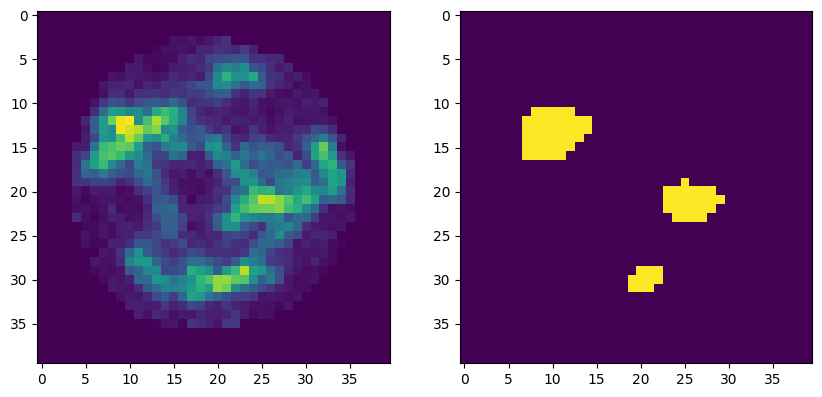

In [64]:
0
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
#plt.imshow(inputs[0][0] )
print('label', masks[0])
ax1.imshow(inputs[0][0])
ax2.imshow(masks[0][0])


In [65]:
 """Cut Mix augmentation """
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)

    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

inputs, masks = next(iter(dataloaders['train']))
inputs_clone = inputs.clone() # clone inputs for mixing
masks_clone = masks.clone() # clone masks for mixing

rand1 = random.uniform(1,4)
rand2 = random.uniform(1,4)

for i in range(inputs.size(0)): # iterate over each image/mask in the batch
    lam = np.random.beta(rand1, rand2)
    rand_index = random.randrange(inputs.size(0))

    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[i, :, bbx1:bbx2, bby1:bby2] = inputs_clone[rand_index, :, bbx1:bbx2, bby1:bby2] # patch image
    masks[i, :, bbx1:bbx2, bby1:bby2] = masks_clone[rand_index, :, bbx1:bbx2, bby1:bby2] # patch mask

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    masks = (masks - masks.min()) / (masks.max() - masks.min()) # renormalize again JUST in case



<ipython-input-65-1fe27e2d3cb9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-65-1fe27e2d3cb9>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det

label tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


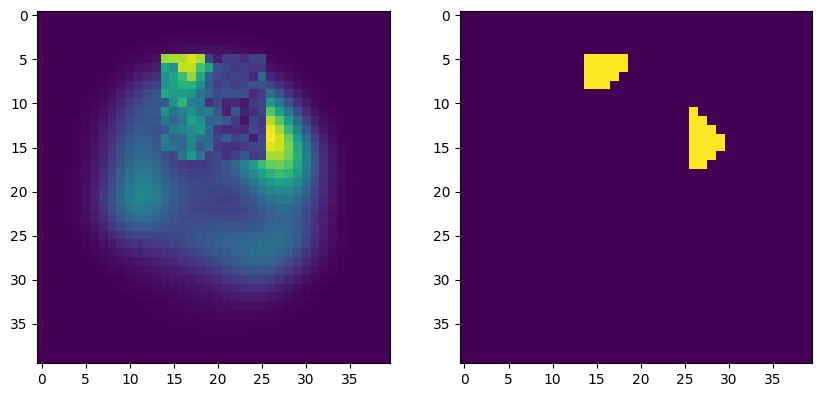

In [69]:
sample =3

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))

print('label', masks[sample])
ax1.imshow(inputs[sample][0])
ax2.imshow(masks[sample][0])

In [14]:
#@title
import torch
import torch.nn as nn
import torch.nn.functional as F

#https://theaisummer.com/unet-architectures/

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [15]:
model = Unet(1,2)

In [16]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device('cpu')

print('device used {}'.format(device))

device used cuda


In [17]:
import time
from torch.optim.lr_scheduler import StepLR

import time
from torch.optim.lr_scheduler import StepLR

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)

    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)
    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    global train_loss, valid_loss
    start = time.time()
    model.to(device)
    scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
    train_loss, valid_loss = [], []
    best_acc = 0.0
    prev_loss = None
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
                dataloader = train_dl
            else:
                model.train(False)
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0
            total = 0

            step = 0

            # iterate over data
            for x, y in dataloader:
                # implement CutMix Augmentation
                if phase == 'train' and random.random() > 0.5:
                    rand1 = random.uniform(1,4)
                    rand2 = random.uniform(1,4)

                    for i in range(x.size(0)): # iterate over each image/mask in the batch
                        lam = np.random.beta(rand1, rand2)
                        rand_index = random.randrange(x.size(0))

                        bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
                        x[i, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2] # patch image
                        y[i, :, bbx1:bbx2, bby1:bby2] = y[rand_index, :, bbx1:bbx2, bby1:bby2] # patch mask

                        # adjust lambda to exactly match pixel ratio
                        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
                        y = (y - y.min()) / (y.max() - y.min()) # renormalize again JUST in case

                # move data to the device
                x = x.to(device).float()
                y = y.to(device).float()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer
                    optimizer.zero_grad()
                    outputs = model(x)
                    outputs= outputs[:,1,:,:]
                    outputs= torch.nan_to_num(outputs, nan=0.0  ) ## added for blank images
                    y = torch.nan_to_num(y, nan=0.0  )## added for blank images

                    loss = loss_fn(outputs , y.squeeze(1).float() )
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        outputs= outputs[:,1,:,:]
                        outputs= torch.nan_to_num(outputs, nan=0.0  ) ## added for blank images
                        y = torch.nan_to_num(y, nan=0.0  )## added for blank images

                        loss = loss_fn(outputs, y.squeeze(1).float())

                # stats - whatever is the phase
                acc = acc_fn(outputs.unsqueeze(1) , y)

                running_acc  += acc
                total += y.size(0)
                running_loss += loss * dataloader.batch_size

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc), 'learning rate {}'.format(scheduler.get_last_lr()))

            epoch_loss = epoch_loss.to('cpu').detach().numpy()
            epoch_acc = epoch_acc.to('cpu').detach().numpy()
            if phase=='train':
                train_loss.append({'epochloss':epoch_loss ,'epochacc': epoch_acc })
            else:
                valid_loss.append({'epochloss':epoch_loss ,'epochacc': epoch_acc })

            # for model saving
            if prev_loss is None:
              prev_loss = epoch_loss
            if (epoch_loss <= prev_loss) and (epoch >35) :  # keeping model with the highest accuracy on validation dataset
              name ='Allcells2_UNET_512_512'
              torch.save(model.state_dict(), path+'/{}.pth'.format(name))
              prev_loss = epoch_loss
              scheduler.step()
              print('newmodel is {}'.format(epoch))

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss


def acc_metric(predb, yb):
    '''use this to calculate accuracy if using the nn.CrossEntropyLoss() '''
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

def acc_metric(y_pred, y_test):
    '''use this to calculate accuracy if using the nn.BCEWithLogitsLoss()'''
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/(y_test.shape[0] * y_test.shape[1]* y_test.shape[2]* y_test.shape[3] )
    acc = torch.round(acc * 100)

    return acc

def acc_metric(y_pred, y_test):
    mask = y_test.to(device) # ensuring the test is on cuda
    _, predicted = torch.max(y_pred.data, 1) # getting the max layer
    total_train =  mask.nelement()
    correct_train = predicted.eq(mask.data).sum().item()
    train_accuracy = 100 * correct_train / total_train
    total_train = mask.nelement()
    return torch.tensor(train_accuracy)


def soft_dice_loss(y_true, y_pred, epsilon=1e-6):
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * torch.sum(y_pred * y_true, axes)
    denominator = torch.sum(y_pred.pow(2) + y_true.pow(2), axes)

    return 1 - torch.mean((numerator + epsilon) / (denominator + epsilon))

In [18]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:

name = 'Allcellsv3_UNET_512_512'#   'DAPI_UNET_512_512' #  'Allcellsv3_UNET_512_512'#
model.load_state_dict(torch.load(path+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # #nn.BCEWithLogitsLoss()   # nn.CrossEntropyLoss()  nn.BCELoss() # soft_dice_loss

opt =  torch.optim.Adam(model.parameters(), lr = .0001)
train_loss, valid_loss = train(model,train_loader,test_loader, loss_fn, opt, acc_metric, epochs =50)

Epoch 0/49
----------


<ipython-input-7-179c8d0994b0>:111: RuntimeWarning: invalid value encountered in true_divide
  mask = (mask - np.min(mask))/minmask   # normalize it to 0-1


train Loss: 0.6855 Acc: 97.4804916381836 learning rate [0.0001]
valid Loss: 0.1884 Acc: 95.96749877929688 learning rate [0.0001]
Epoch 1/49
----------
train Loss: 0.4403 Acc: 97.48228454589844 learning rate [0.0001]
valid Loss: 0.1801 Acc: 95.96749877929688 learning rate [0.0001]
Epoch 2/49
----------
train Loss: 0.2681 Acc: 97.50099182128906 learning rate [0.0001]
valid Loss: 0.1566 Acc: 95.96749877929688 learning rate [0.0001]
Epoch 3/49
----------
train Loss: 0.1769 Acc: 97.38833618164062 learning rate [0.0001]
valid Loss: 0.1400 Acc: 95.96749877929688 learning rate [0.0001]
Epoch 4/49
----------
train Loss: 0.1204 Acc: 97.41461181640625 learning rate [0.0001]
valid Loss: 0.1108 Acc: 95.96749877929688 learning rate [0.0001]
Epoch 5/49
----------
train Loss: 0.0913 Acc: 97.45521545410156 learning rate [0.0001]
valid Loss: 0.1034 Acc: 95.96749877929688 learning rate [0.0001]
Epoch 6/49
----------
train Loss: 0.0812 Acc: 97.45720672607422 learning rate [0.0001]
valid Loss: 0.0931 Acc: 

In [ ]:
## Saving the model
name = 'Foci_Unet'#
torch.save(model.state_dict(), path+'/{}.pth'.format(name))

train = pd.DataFrame(train_loss)
valid = pd.DataFrame(valid_loss)



train.to_csv('train_{}'.format(name), sep = '\t')

valid.to_csv('valid_{}'.format(name), sep = '\t')


Text(0, 0.5, 'Loss')

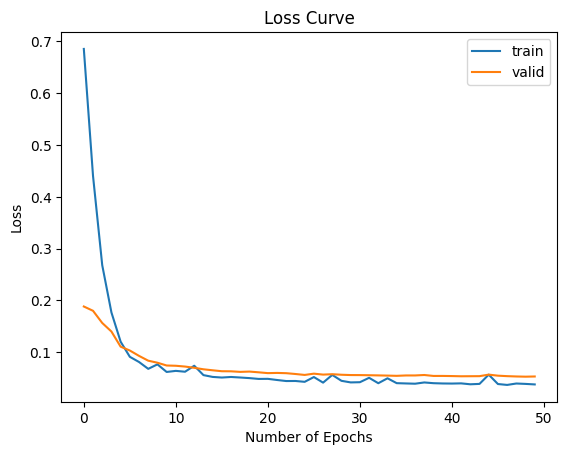

In [ ]:
plt.plot(train['epochloss'])
plt.plot(valid['epochloss'])
plt.legend(['train', 'valid'])
plt.title('Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

In [ ]:
from skimage.segmentation import watershed
def watershedmask(mask, nucleus ):
    '''Here I am applying watershed to the outputted model, this will help further seperate cells that may be
    super close to each other or any other mother cell'''
    distance = ndimage.distance_transform_edt(nucleus)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)), labels= mask)
    markers = morphology.label(local_maxi)
    mask = watershed(-distance, markers, mask=mask)
    #mask = morphology.remove_small_objects(labels, min_size=50)
    return mask

In [ ]:
path

'/content/drive/My Drive/unet/training_data'

In [ ]:
name ='Foci_Unet' # #'yeazlaplacian_UNET_512_512' #'laplacian_UNET_512_512' # 'laplacian_UNET_512_512' #'yeaz_UNET_512_512'#'laplacian_UNET_512_512'#'UNET_512_512'#'MMD_VAE_preBinary_volthresh' #'63MMD_VAE_volThresh' #'MMD_VAE_preBinary_volthresh' #MMD_VAE_Binary MMD_VAE_preBinary_volthresh
model.load_state_dict(torch.load(path+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above
model.eval()

torch.Size([25, 1, 40, 40]) torch.Size([25, 1, 40, 40])
label tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


<ipython-input-7-a71c963db606>:111: RuntimeWarning: invalid value encountered in true_divide
  mask = (mask - np.min(mask))/minmask   # normalize it to 0-1


torch.Size([25, 1, 40, 40])

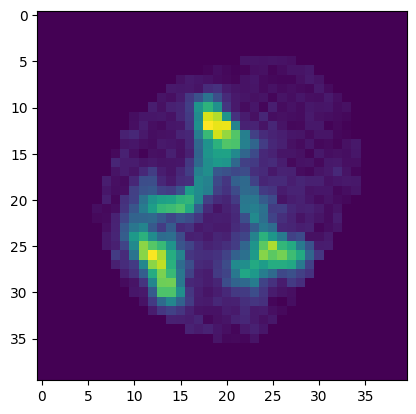

In [30]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['val']))

print(inputs.shape, masks.shape)
#f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
plt.imshow(inputs[0][0] )
print('label', masks[0])
#ax1.imshow(inputs[0][0])
#ax2.imshow(masks[0][0])

# grab a batch from the train loader
batch, classes = next(iter(train_loader))
batch.shape

In [31]:
pred = model(inputs.to(device).float()  ).to('cpu').detach().numpy()


Text(0.5, 1.0, 'Overlay of Model output')

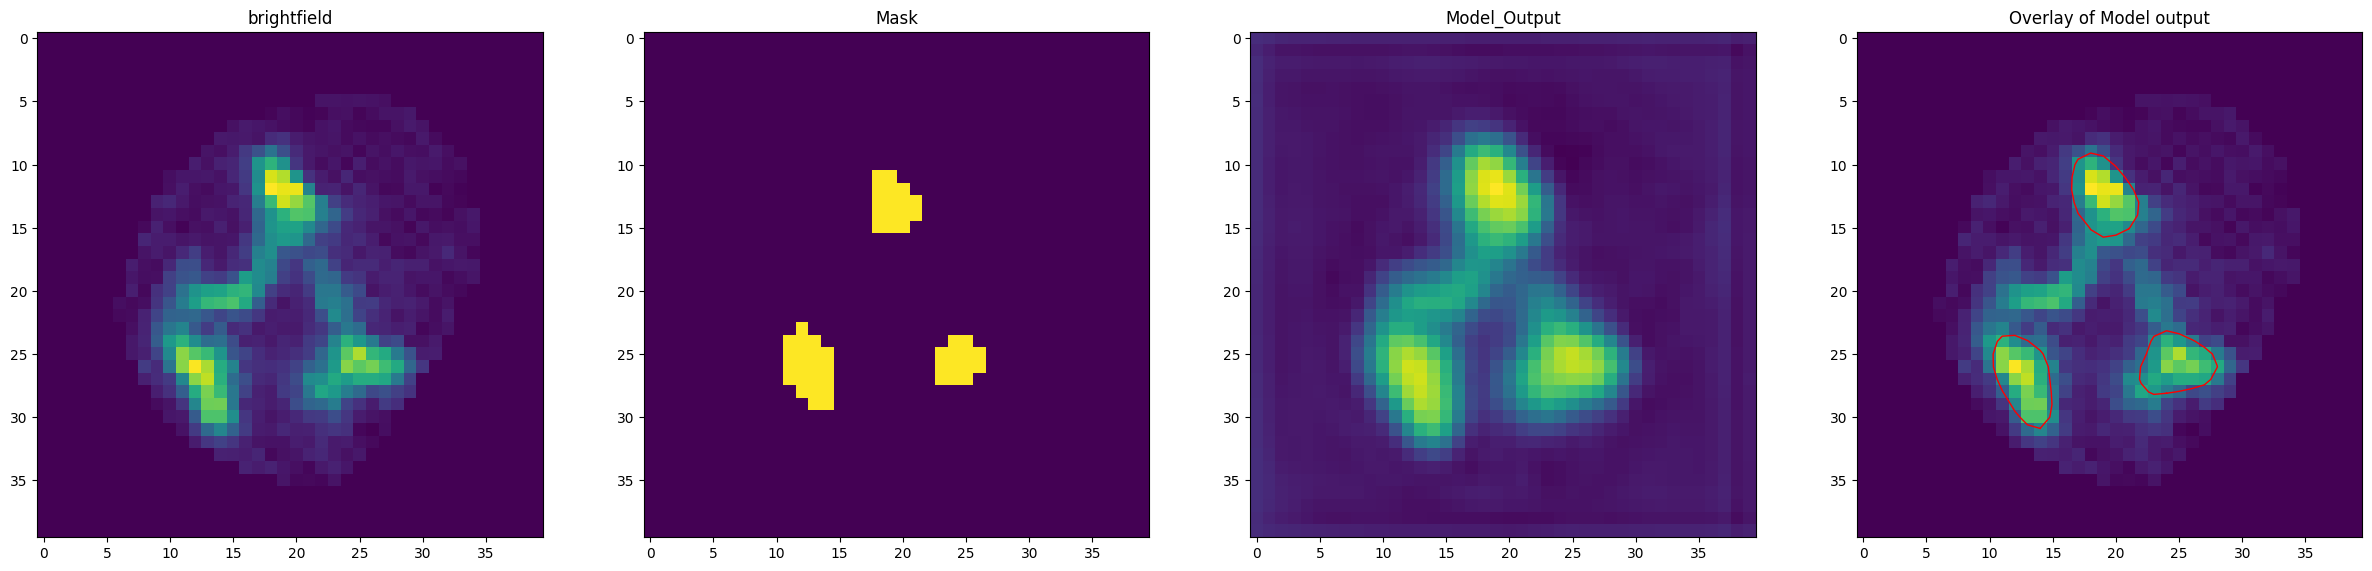

In [37]:
from pandas.core.strings.object_array import ObjectStringArrayMixin
from scipy import ndimage
#from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology




f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (30,30))
samp =0
ax1.imshow(inputs[samp,0,:,:])
ax2.imshow(masks[samp,:,:][0])

thresh = pred[samp,1,:,:].mean()  + (.8* (pred[samp, 1, :,:]).std())

sample = pred[samp, 1, :,:]
mask = sample.copy()
#maxgmm, mingmm = gausmix( sample )

mask = mask  #>  maxgmm*1.2
### watershed
image = pred[samp, 1, :,:]
#mask = watershedmask(mask,sample)

#mask1 = ndi.binary_dilation(ndi.gaussian_filter(mask, sigma = 1), iterations=2)

ax3.imshow(mask)

maskactual=masks[samp,:,:][0].to('cpu').detach().numpy()

ax4.imshow(inputs[samp,0,:,:])


contours = find_contours(mask, .01) # finds the corresponding peaks and draws it on the picture
for contour in contours:
   ax4.plot(contour[:, 1], contour[:, 0], linewidth=1, color='r')



ax1.set_title('brightfield')
ax2.set_title('Mask')
ax3.set_title('Model_Output')
ax4.set_title('Overlay of Model output')